# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

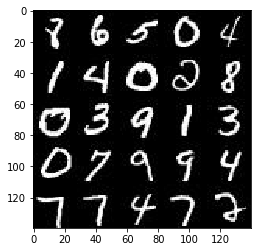

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

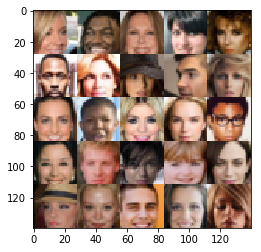

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/slash.wang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [65]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    input_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return input_img_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [64]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    构建辨别器网络
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse) :
        layer1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha*layer1, layer1)
        
        layer2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='SAME')
        batch_normal = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * batch_normal, batch_normal)
        
        flat = tf.reshape(relu2, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [63]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    生成器
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        layer1 = tf.layers.dense(z, 7*7*256)
        layer1 = tf.reshape(layer1, (-1, 7,7,256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(layer1 * alpha, layer1)
        
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='SAME')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(layer2 * alpha, layer2)
        
        logits = tf.layers.conv2d_transpose(layer2, out_channel_dim, 5, strides=2, padding='SAME')
        
        output = tf.tanh(logits)
        return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [66]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    dis_out_real, dis_logits_real = discriminator(input_real, reuse=False)
    gen_out = generator(input_z, out_channel_dim, is_train=True)
    dis_out_fake, dis_logits_fake = discriminator(gen_out, reuse=True)
    
    dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_out_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_out_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_out_fake)))
    dis_loss = dis_loss_fake + dis_loss_real
    return dis_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [67]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    对模型进行优化
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    dis_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    dis_update_ops = [var for var in update_ops if var.name.startswith('discriminator')]
    gen_update_ops = [var for var in update_ops if var.name.startswith('generator')]
    
    with tf.control_dependencies(dis_update_ops):
        dis_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
    with tf.control_dependencies(gen_update_ops):
        gen_train_ops = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    return dis_train_ops, gen_train_ops
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [68]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [69]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     构建训练模型
    input_data_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim=z_dim)
    dis_loss, gen_loss = model_loss(input_data_real, input_z, data_shape[3])
    dis_opt, gen_opt = model_opt(dis_loss, gen_loss, learning_rate=learning_rate, beta1=beta1)
    
    process = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
#                 开始训练
                process += 1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                    
                sess.run(dis_opt, feed_dict={
                    input_data_real: batch_images, 
                    input_z: batch_z, 
                    input_learning_rate: learning_rate
                })
                sess.run(gen_opt, feed_dict={
                    input_z: batch_z,
                    input_learning_rate:learning_rate
                })
                
                if process % 10==0:
                    dis_train_loss = dis_loss.eval({
                        input_z:batch_z,
                        input_data_real:batch_images
                    })
                    gen_train_loss = gen_loss.eval({
                        input_z:batch_z
                    })
                    print("Epoch {}/{}---process:{}".format(epoch_i+1, epochs, process),
                         "Loss of Discriminator: {}---".format(dis_train_loss),
                         "Loss of Generator: {}---".format(gen_train_loss))
                    
                if process%100==0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
            
            print("Loss of Discriminator: {}---".format(dis_train_loss),
                 "Loss of Generator: {}---".format(gen_train_loss))
            show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2---process:10 Loss of Discriminator: 0.7224961519241333--- Loss of Generator: 1.4196033477783203---
Epoch 1/2---process:20 Loss of Discriminator: 1.1234080791473389--- Loss of Generator: 0.8285231590270996---
Epoch 1/2---process:30 Loss of Discriminator: 0.9742043018341064--- Loss of Generator: 2.537975311279297---
Epoch 1/2---process:40 Loss of Discriminator: 0.8165633082389832--- Loss of Generator: 2.3862946033477783---
Epoch 1/2---process:50 Loss of Discriminator: 0.8279954195022583--- Loss of Generator: 1.175915241241455---
Epoch 1/2---process:60 Loss of Discriminator: 1.0971040725708008--- Loss of Generator: 1.842986822128296---
Epoch 1/2---process:70 Loss of Discriminator: 1.0117785930633545--- Loss of Generator: 1.6593356132507324---
Epoch 1/2---process:80 Loss of Discriminator: 1.1096539497375488--- Loss of Generator: 2.1826438903808594---
Epoch 1/2---process:90 Loss of Discriminator: 1.4001834392547607--- Loss of Generator: 0.46417149901390076---
Epoch 1/2---process:1

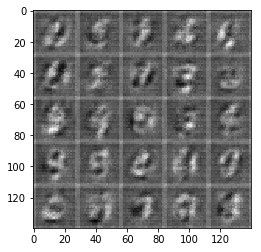

Epoch 1/2---process:110 Loss of Discriminator: 1.1854984760284424--- Loss of Generator: 0.6413307785987854---
Epoch 1/2---process:120 Loss of Discriminator: 1.0013322830200195--- Loss of Generator: 1.4679672718048096---
Epoch 1/2---process:130 Loss of Discriminator: 0.9345300793647766--- Loss of Generator: 1.4172415733337402---
Epoch 1/2---process:140 Loss of Discriminator: 0.9430443048477173--- Loss of Generator: 1.0707894563674927---
Epoch 1/2---process:150 Loss of Discriminator: 0.9740563631057739--- Loss of Generator: 1.3020901679992676---
Epoch 1/2---process:160 Loss of Discriminator: 1.1070188283920288--- Loss of Generator: 0.7628176212310791---
Epoch 1/2---process:170 Loss of Discriminator: 1.2458802461624146--- Loss of Generator: 0.5737187266349792---
Epoch 1/2---process:180 Loss of Discriminator: 1.3108313083648682--- Loss of Generator: 0.5314170122146606---
Epoch 1/2---process:190 Loss of Discriminator: 1.1190714836120605--- Loss of Generator: 0.693846583366394---
Epoch 1/2--

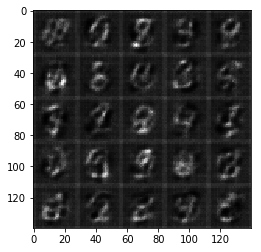

Epoch 1/2---process:210 Loss of Discriminator: 1.0015699863433838--- Loss of Generator: 1.4127717018127441---
Epoch 1/2---process:220 Loss of Discriminator: 1.059525966644287--- Loss of Generator: 0.8139326572418213---
Epoch 1/2---process:230 Loss of Discriminator: 1.0333751440048218--- Loss of Generator: 0.8046779632568359---
Epoch 1/2---process:240 Loss of Discriminator: 0.9368771910667419--- Loss of Generator: 1.6173532009124756---
Epoch 1/2---process:250 Loss of Discriminator: 0.9030991792678833--- Loss of Generator: 1.2820613384246826---
Epoch 1/2---process:260 Loss of Discriminator: 0.9253053665161133--- Loss of Generator: 1.4360032081604004---
Epoch 1/2---process:270 Loss of Discriminator: 0.8992966413497925--- Loss of Generator: 1.116593599319458---
Epoch 1/2---process:280 Loss of Discriminator: 0.9043011665344238--- Loss of Generator: 1.5507118701934814---
Epoch 1/2---process:290 Loss of Discriminator: 0.9803075790405273--- Loss of Generator: 1.7350788116455078---
Epoch 1/2---

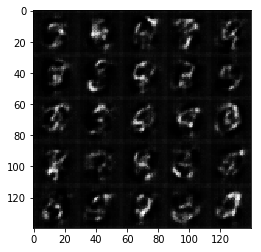

Epoch 1/2---process:310 Loss of Discriminator: 0.9009647369384766--- Loss of Generator: 1.032742977142334---
Epoch 1/2---process:320 Loss of Discriminator: 0.927857518196106--- Loss of Generator: 1.9387565851211548---
Epoch 1/2---process:330 Loss of Discriminator: 0.8898916840553284--- Loss of Generator: 1.6729674339294434---
Epoch 1/2---process:340 Loss of Discriminator: 0.8557394742965698--- Loss of Generator: 1.2972956895828247---
Epoch 1/2---process:350 Loss of Discriminator: 0.9011358618736267--- Loss of Generator: 1.88140070438385---
Epoch 1/2---process:360 Loss of Discriminator: 0.8684809803962708--- Loss of Generator: 1.1469495296478271---
Epoch 1/2---process:370 Loss of Discriminator: 0.7603767514228821--- Loss of Generator: 1.5310025215148926---
Epoch 1/2---process:380 Loss of Discriminator: 0.8140976428985596--- Loss of Generator: 1.3374502658843994---
Epoch 1/2---process:390 Loss of Discriminator: 0.7985848188400269--- Loss of Generator: 2.149508237838745---
Epoch 1/2---pro

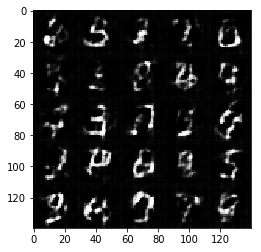

Epoch 1/2---process:410 Loss of Discriminator: 1.0693656206130981--- Loss of Generator: 0.7643610835075378---
Epoch 1/2---process:420 Loss of Discriminator: 0.7896496653556824--- Loss of Generator: 1.856996774673462---
Epoch 1/2---process:430 Loss of Discriminator: 0.930934488773346--- Loss of Generator: 2.318175792694092---
Epoch 1/2---process:440 Loss of Discriminator: 0.7662878632545471--- Loss of Generator: 1.4770159721374512---
Epoch 1/2---process:450 Loss of Discriminator: 0.8047202825546265--- Loss of Generator: 1.2613372802734375---
Epoch 1/2---process:460 Loss of Discriminator: 0.87315434217453--- Loss of Generator: 1.1251227855682373---
Loss of Discriminator: 0.87315434217453--- Loss of Generator: 1.1251227855682373---


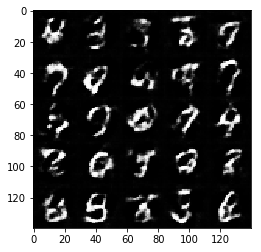

Epoch 2/2---process:470 Loss of Discriminator: 0.8744563460350037--- Loss of Generator: 2.0575432777404785---
Epoch 2/2---process:480 Loss of Discriminator: 0.8447258472442627--- Loss of Generator: 2.084463596343994---
Epoch 2/2---process:490 Loss of Discriminator: 0.8868485689163208--- Loss of Generator: 1.0763490200042725---
Epoch 2/2---process:500 Loss of Discriminator: 0.8879517912864685--- Loss of Generator: 1.9987232685089111---


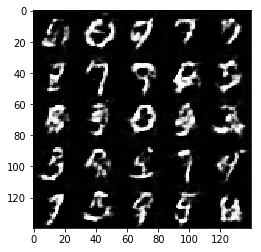

Epoch 2/2---process:510 Loss of Discriminator: 0.8558521270751953--- Loss of Generator: 1.2334531545639038---
Epoch 2/2---process:520 Loss of Discriminator: 0.8371186852455139--- Loss of Generator: 1.7182002067565918---
Epoch 2/2---process:530 Loss of Discriminator: 0.8620280027389526--- Loss of Generator: 1.6780948638916016---
Epoch 2/2---process:540 Loss of Discriminator: 0.8314374685287476--- Loss of Generator: 1.238842487335205---
Epoch 2/2---process:550 Loss of Discriminator: 0.8031538128852844--- Loss of Generator: 1.4336727857589722---
Epoch 2/2---process:560 Loss of Discriminator: 0.9059312343597412--- Loss of Generator: 2.2746622562408447---
Epoch 2/2---process:570 Loss of Discriminator: 0.9888733625411987--- Loss of Generator: 2.264528512954712---
Epoch 2/2---process:580 Loss of Discriminator: 0.9309349656105042--- Loss of Generator: 1.877385139465332---
Epoch 2/2---process:590 Loss of Discriminator: 0.8340518474578857--- Loss of Generator: 1.3511717319488525---
Epoch 2/2---p

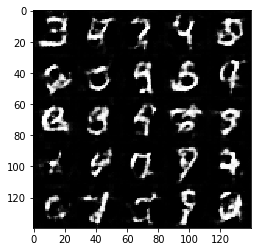

Epoch 2/2---process:610 Loss of Discriminator: 0.9171484708786011--- Loss of Generator: 1.6643593311309814---
Epoch 2/2---process:620 Loss of Discriminator: 1.0489856004714966--- Loss of Generator: 2.1193554401397705---
Epoch 2/2---process:630 Loss of Discriminator: 1.1609461307525635--- Loss of Generator: 0.6884275078773499---
Epoch 2/2---process:640 Loss of Discriminator: 1.0066218376159668--- Loss of Generator: 0.8493874073028564---
Epoch 2/2---process:650 Loss of Discriminator: 0.9133657217025757--- Loss of Generator: 1.1305350065231323---
Epoch 2/2---process:660 Loss of Discriminator: 1.0164251327514648--- Loss of Generator: 0.871594250202179---
Epoch 2/2---process:670 Loss of Discriminator: 0.8612414598464966--- Loss of Generator: 1.4296903610229492---
Epoch 2/2---process:680 Loss of Discriminator: 1.1516616344451904--- Loss of Generator: 0.6728394031524658---
Epoch 2/2---process:690 Loss of Discriminator: 1.1459565162658691--- Loss of Generator: 0.6955286264419556---
Epoch 2/2--

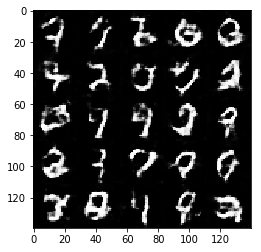

Epoch 2/2---process:710 Loss of Discriminator: 0.9966228604316711--- Loss of Generator: 1.5140184164047241---
Epoch 2/2---process:720 Loss of Discriminator: 0.9324977397918701--- Loss of Generator: 1.1293809413909912---
Epoch 2/2---process:730 Loss of Discriminator: 0.9527907371520996--- Loss of Generator: 1.33502197265625---
Epoch 2/2---process:740 Loss of Discriminator: 0.9671237468719482--- Loss of Generator: 1.176324486732483---
Epoch 2/2---process:750 Loss of Discriminator: 0.9081063270568848--- Loss of Generator: 1.2882035970687866---
Epoch 2/2---process:760 Loss of Discriminator: 0.8989734053611755--- Loss of Generator: 1.243732213973999---
Epoch 2/2---process:770 Loss of Discriminator: 1.029149055480957--- Loss of Generator: 1.558984398841858---
Epoch 2/2---process:780 Loss of Discriminator: 0.9394890069961548--- Loss of Generator: 0.9799337983131409---
Epoch 2/2---process:790 Loss of Discriminator: 0.9961673021316528--- Loss of Generator: 1.8374829292297363---
Epoch 2/2---proc

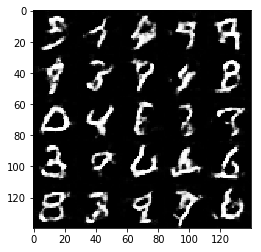

Epoch 2/2---process:810 Loss of Discriminator: 0.9300288558006287--- Loss of Generator: 1.528670310974121---
Epoch 2/2---process:820 Loss of Discriminator: 0.9997687339782715--- Loss of Generator: 1.0524520874023438---
Epoch 2/2---process:830 Loss of Discriminator: 0.9564701318740845--- Loss of Generator: 1.4214513301849365---
Epoch 2/2---process:840 Loss of Discriminator: 0.997302770614624--- Loss of Generator: 1.6583428382873535---
Epoch 2/2---process:850 Loss of Discriminator: 1.0103952884674072--- Loss of Generator: 0.9961029291152954---
Epoch 2/2---process:860 Loss of Discriminator: 1.0217467546463013--- Loss of Generator: 1.978628396987915---
Epoch 2/2---process:870 Loss of Discriminator: 1.1201926469802856--- Loss of Generator: 0.8171419501304626---
Epoch 2/2---process:880 Loss of Discriminator: 1.0452979803085327--- Loss of Generator: 0.8314495086669922---
Epoch 2/2---process:890 Loss of Discriminator: 1.0421029329299927--- Loss of Generator: 0.8273743987083435---
Epoch 2/2---p

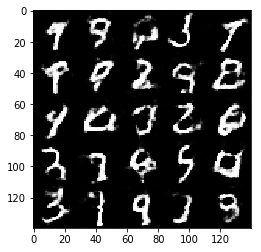

Epoch 2/2---process:910 Loss of Discriminator: 1.0313951969146729--- Loss of Generator: 0.9984725117683411---
Epoch 2/2---process:920 Loss of Discriminator: 0.9786977171897888--- Loss of Generator: 0.988515317440033---
Epoch 2/2---process:930 Loss of Discriminator: 0.9101892709732056--- Loss of Generator: 1.5862005949020386---
Loss of Discriminator: 0.9101892709732056--- Loss of Generator: 1.5862005949020386---


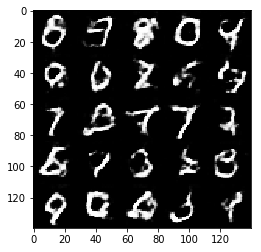

In [70]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1---process:10 Loss of Discriminator: 0.7580297589302063--- Loss of Generator: 1.5448617935180664---
Epoch 1/1---process:20 Loss of Discriminator: 0.6333585977554321--- Loss of Generator: 2.2435708045959473---
Epoch 1/1---process:30 Loss of Discriminator: 0.5373779535293579--- Loss of Generator: 2.2296905517578125---
Epoch 1/1---process:40 Loss of Discriminator: 0.4993324875831604--- Loss of Generator: 2.8091049194335938---
Epoch 1/1---process:50 Loss of Discriminator: 1.7343409061431885--- Loss of Generator: 0.4202847480773926---
Epoch 1/1---process:60 Loss of Discriminator: 1.0875885486602783--- Loss of Generator: 0.8312364816665649---
Epoch 1/1---process:70 Loss of Discriminator: 1.0514016151428223--- Loss of Generator: 1.0509920120239258---
Epoch 1/1---process:80 Loss of Discriminator: 0.9534174799919128--- Loss of Generator: 2.3591647148132324---
Epoch 1/1---process:90 Loss of Discriminator: 0.9921995401382446--- Loss of Generator: 0.9706308841705322---
Epoch 1/1---process

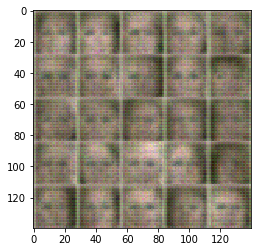

Epoch 1/1---process:110 Loss of Discriminator: 0.9334592819213867--- Loss of Generator: 1.111354947090149---
Epoch 1/1---process:120 Loss of Discriminator: 0.9048925638198853--- Loss of Generator: 1.6650662422180176---
Epoch 1/1---process:130 Loss of Discriminator: 0.840563952922821--- Loss of Generator: 1.9418882131576538---
Epoch 1/1---process:140 Loss of Discriminator: 0.7415518760681152--- Loss of Generator: 1.5105717182159424---
Epoch 1/1---process:150 Loss of Discriminator: 1.2284784317016602--- Loss of Generator: 0.6701120138168335---
Epoch 1/1---process:160 Loss of Discriminator: 1.7561389207839966--- Loss of Generator: 3.736009120941162---
Epoch 1/1---process:170 Loss of Discriminator: 1.0658434629440308--- Loss of Generator: 1.103972315788269---
Epoch 1/1---process:180 Loss of Discriminator: 1.0406688451766968--- Loss of Generator: 1.1107630729675293---
Epoch 1/1---process:190 Loss of Discriminator: 1.134287714958191--- Loss of Generator: 1.244991660118103---
Epoch 1/1---proc

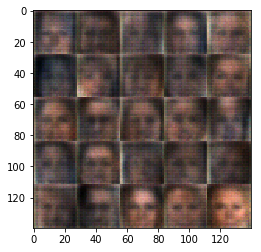

Epoch 1/1---process:210 Loss of Discriminator: 1.0744282007217407--- Loss of Generator: 1.2683513164520264---
Epoch 1/1---process:220 Loss of Discriminator: 0.9739698767662048--- Loss of Generator: 1.02390456199646---
Epoch 1/1---process:230 Loss of Discriminator: 1.3141133785247803--- Loss of Generator: 2.492180585861206---
Epoch 1/1---process:240 Loss of Discriminator: 1.0008442401885986--- Loss of Generator: 1.1492477655410767---
Epoch 1/1---process:250 Loss of Discriminator: 1.5732768774032593--- Loss of Generator: 2.366041898727417---
Epoch 1/1---process:260 Loss of Discriminator: 0.899794340133667--- Loss of Generator: 1.6208882331848145---
Epoch 1/1---process:270 Loss of Discriminator: 1.0807414054870605--- Loss of Generator: 0.8596364855766296---
Epoch 1/1---process:280 Loss of Discriminator: 1.0286380052566528--- Loss of Generator: 0.9036255478858948---
Epoch 1/1---process:290 Loss of Discriminator: 1.071035385131836--- Loss of Generator: 1.3030204772949219---
Epoch 1/1---proc

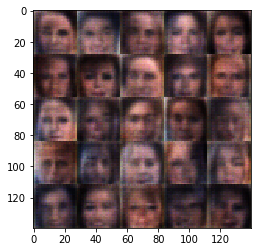

Epoch 1/1---process:310 Loss of Discriminator: 1.1516804695129395--- Loss of Generator: 1.098337173461914---
Epoch 1/1---process:320 Loss of Discriminator: 1.075714111328125--- Loss of Generator: 1.6703592538833618---
Epoch 1/1---process:330 Loss of Discriminator: 0.8843793869018555--- Loss of Generator: 1.8645485639572144---
Epoch 1/1---process:340 Loss of Discriminator: 1.4517844915390015--- Loss of Generator: 2.3756327629089355---
Epoch 1/1---process:350 Loss of Discriminator: 0.9914924502372742--- Loss of Generator: 1.5890672206878662---
Epoch 1/1---process:360 Loss of Discriminator: 0.8538865447044373--- Loss of Generator: 1.6321747303009033---
Epoch 1/1---process:370 Loss of Discriminator: 0.9271377325057983--- Loss of Generator: 1.1625583171844482---
Epoch 1/1---process:380 Loss of Discriminator: 0.9843220710754395--- Loss of Generator: 1.5548174381256104---
Epoch 1/1---process:390 Loss of Discriminator: 0.8245909810066223--- Loss of Generator: 1.5499989986419678---
Epoch 1/1---

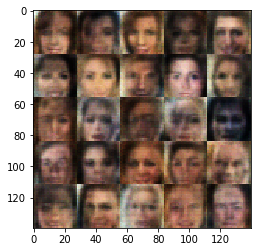

Epoch 1/1---process:410 Loss of Discriminator: 1.6026273965835571--- Loss of Generator: 0.43113523721694946---
Epoch 1/1---process:420 Loss of Discriminator: 0.9317085146903992--- Loss of Generator: 1.5362114906311035---
Epoch 1/1---process:430 Loss of Discriminator: 1.0147554874420166--- Loss of Generator: 1.1975102424621582---
Epoch 1/1---process:440 Loss of Discriminator: 0.8945838809013367--- Loss of Generator: 1.3387445211410522---
Epoch 1/1---process:450 Loss of Discriminator: 0.9373089671134949--- Loss of Generator: 1.2135921716690063---
Epoch 1/1---process:460 Loss of Discriminator: 0.8442600965499878--- Loss of Generator: 1.2620818614959717---
Epoch 1/1---process:470 Loss of Discriminator: 0.8313297033309937--- Loss of Generator: 1.47103750705719---
Epoch 1/1---process:480 Loss of Discriminator: 0.9608486890792847--- Loss of Generator: 1.9787945747375488---
Epoch 1/1---process:490 Loss of Discriminator: 1.0923118591308594--- Loss of Generator: 2.1998682022094727---
Epoch 1/1--

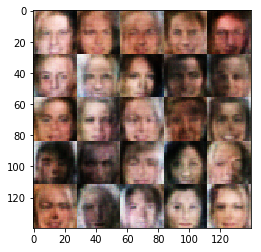

Epoch 1/1---process:510 Loss of Discriminator: 0.9903384447097778--- Loss of Generator: 1.2996588945388794---
Epoch 1/1---process:520 Loss of Discriminator: 0.9648523330688477--- Loss of Generator: 1.3820853233337402---
Epoch 1/1---process:530 Loss of Discriminator: 0.938934326171875--- Loss of Generator: 1.1033422946929932---
Epoch 1/1---process:540 Loss of Discriminator: 0.9506439566612244--- Loss of Generator: 1.5698513984680176---
Epoch 1/1---process:550 Loss of Discriminator: 0.9470247626304626--- Loss of Generator: 1.860012412071228---
Epoch 1/1---process:560 Loss of Discriminator: 1.1213243007659912--- Loss of Generator: 0.9794759750366211---
Epoch 1/1---process:570 Loss of Discriminator: 1.0932599306106567--- Loss of Generator: 1.4719158411026---
Epoch 1/1---process:580 Loss of Discriminator: 0.9133028388023376--- Loss of Generator: 1.3719305992126465---
Epoch 1/1---process:590 Loss of Discriminator: 0.9854301810264587--- Loss of Generator: 1.2642024755477905---
Epoch 1/1---pro

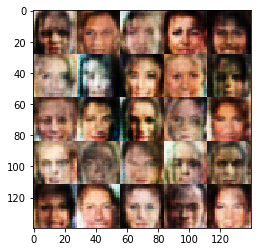

Epoch 1/1---process:610 Loss of Discriminator: 1.1982907056808472--- Loss of Generator: 1.0055835247039795---
Epoch 1/1---process:620 Loss of Discriminator: 1.2454217672348022--- Loss of Generator: 0.6757813692092896---
Epoch 1/1---process:630 Loss of Discriminator: 1.1541848182678223--- Loss of Generator: 0.9947361946105957---
Epoch 1/1---process:640 Loss of Discriminator: 1.1630325317382812--- Loss of Generator: 0.8200336694717407---
Epoch 1/1---process:650 Loss of Discriminator: 1.0601227283477783--- Loss of Generator: 0.9001888632774353---
Epoch 1/1---process:660 Loss of Discriminator: 1.100774884223938--- Loss of Generator: 1.3343244791030884---
Epoch 1/1---process:670 Loss of Discriminator: 1.177071213722229--- Loss of Generator: 1.1767714023590088---
Epoch 1/1---process:680 Loss of Discriminator: 1.3888574838638306--- Loss of Generator: 1.3379969596862793---
Epoch 1/1---process:690 Loss of Discriminator: 1.2141519784927368--- Loss of Generator: 1.1045808792114258---
Epoch 1/1---

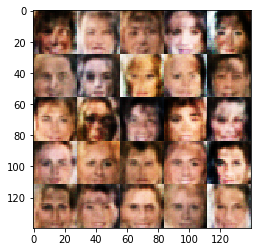

Epoch 1/1---process:710 Loss of Discriminator: 1.3300597667694092--- Loss of Generator: 0.6611739993095398---
Epoch 1/1---process:720 Loss of Discriminator: 1.3530704975128174--- Loss of Generator: 0.701690673828125---
Epoch 1/1---process:730 Loss of Discriminator: 1.108209490776062--- Loss of Generator: 1.038468599319458---
Epoch 1/1---process:740 Loss of Discriminator: 1.3064411878585815--- Loss of Generator: 0.9197654724121094---
Epoch 1/1---process:750 Loss of Discriminator: 1.1878142356872559--- Loss of Generator: 0.8998355865478516---
Epoch 1/1---process:760 Loss of Discriminator: 1.3098794221878052--- Loss of Generator: 1.0928027629852295---
Epoch 1/1---process:770 Loss of Discriminator: 1.3648618459701538--- Loss of Generator: 1.026887059211731---
Epoch 1/1---process:780 Loss of Discriminator: 1.3336511850357056--- Loss of Generator: 0.7241303324699402---
Epoch 1/1---process:790 Loss of Discriminator: 1.3472988605499268--- Loss of Generator: 0.7345550060272217---
Epoch 1/1---pr

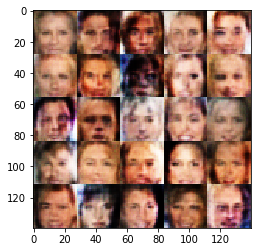

Epoch 1/1---process:810 Loss of Discriminator: 1.2686630487442017--- Loss of Generator: 0.9830910563468933---
Epoch 1/1---process:820 Loss of Discriminator: 1.1215903759002686--- Loss of Generator: 1.0614144802093506---
Epoch 1/1---process:830 Loss of Discriminator: 1.1153478622436523--- Loss of Generator: 1.1817899942398071---
Epoch 1/1---process:840 Loss of Discriminator: 1.198397159576416--- Loss of Generator: 1.079930067062378---
Epoch 1/1---process:850 Loss of Discriminator: 1.1299370527267456--- Loss of Generator: 1.1301212310791016---
Epoch 1/1---process:860 Loss of Discriminator: 1.3337451219558716--- Loss of Generator: 0.6596695184707642---
Epoch 1/1---process:870 Loss of Discriminator: 1.120697021484375--- Loss of Generator: 1.0128533840179443---
Epoch 1/1---process:880 Loss of Discriminator: 1.2323631048202515--- Loss of Generator: 1.0652925968170166---
Epoch 1/1---process:890 Loss of Discriminator: 1.212660789489746--- Loss of Generator: 0.8429179191589355---
Epoch 1/1---pr

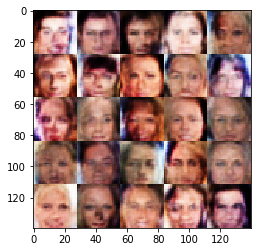

Epoch 1/1---process:910 Loss of Discriminator: 1.1584246158599854--- Loss of Generator: 0.9366405010223389---
Epoch 1/1---process:920 Loss of Discriminator: 1.1987080574035645--- Loss of Generator: 0.9046149253845215---
Epoch 1/1---process:930 Loss of Discriminator: 1.194690227508545--- Loss of Generator: 0.8597840666770935---
Epoch 1/1---process:940 Loss of Discriminator: 1.2931365966796875--- Loss of Generator: 0.9593018293380737---
Epoch 1/1---process:950 Loss of Discriminator: 1.0833206176757812--- Loss of Generator: 1.123481035232544---
Epoch 1/1---process:960 Loss of Discriminator: 1.2562637329101562--- Loss of Generator: 0.8581479787826538---
Epoch 1/1---process:970 Loss of Discriminator: 1.0919742584228516--- Loss of Generator: 1.0668468475341797---
Epoch 1/1---process:980 Loss of Discriminator: 1.085561990737915--- Loss of Generator: 1.04197096824646---
Epoch 1/1---process:990 Loss of Discriminator: 1.1631942987442017--- Loss of Generator: 1.0372693538665771---
Epoch 1/1---pro

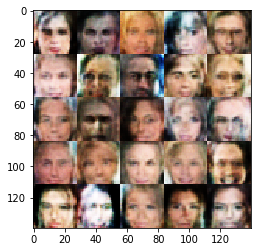

Epoch 1/1---process:1010 Loss of Discriminator: 1.1966737508773804--- Loss of Generator: 1.2201143503189087---
Epoch 1/1---process:1020 Loss of Discriminator: 1.0341863632202148--- Loss of Generator: 1.225541114807129---
Epoch 1/1---process:1030 Loss of Discriminator: 1.2977546453475952--- Loss of Generator: 0.6817442178726196---
Epoch 1/1---process:1040 Loss of Discriminator: 1.130059003829956--- Loss of Generator: 0.8054282069206238---
Epoch 1/1---process:1050 Loss of Discriminator: 1.0914816856384277--- Loss of Generator: 1.0360093116760254---
Epoch 1/1---process:1060 Loss of Discriminator: 1.177524209022522--- Loss of Generator: 0.9483121633529663---
Epoch 1/1---process:1070 Loss of Discriminator: 1.1190639734268188--- Loss of Generator: 1.306161880493164---
Epoch 1/1---process:1080 Loss of Discriminator: 1.212956190109253--- Loss of Generator: 0.8888487219810486---
Epoch 1/1---process:1090 Loss of Discriminator: 1.1372926235198975--- Loss of Generator: 0.9273662567138672---
Epoch 

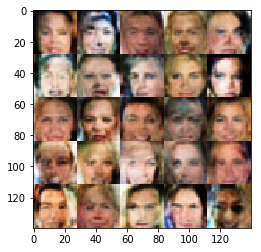

Epoch 1/1---process:1110 Loss of Discriminator: 1.3704447746276855--- Loss of Generator: 1.5796477794647217---
Epoch 1/1---process:1120 Loss of Discriminator: 1.1322016716003418--- Loss of Generator: 0.9177120923995972---
Epoch 1/1---process:1130 Loss of Discriminator: 1.0850640535354614--- Loss of Generator: 1.0236306190490723---
Epoch 1/1---process:1140 Loss of Discriminator: 1.156483769416809--- Loss of Generator: 0.8121060132980347---
Epoch 1/1---process:1150 Loss of Discriminator: 1.0533528327941895--- Loss of Generator: 1.3652386665344238---
Epoch 1/1---process:1160 Loss of Discriminator: 1.0490357875823975--- Loss of Generator: 1.4635242223739624---
Epoch 1/1---process:1170 Loss of Discriminator: 1.140239953994751--- Loss of Generator: 1.455822467803955---
Epoch 1/1---process:1180 Loss of Discriminator: 1.1628834009170532--- Loss of Generator: 1.6815447807312012---
Epoch 1/1---process:1190 Loss of Discriminator: 1.2565033435821533--- Loss of Generator: 2.0727734565734863---
Epoc

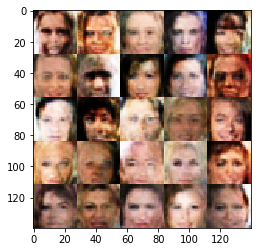

Epoch 1/1---process:1210 Loss of Discriminator: 1.2686744928359985--- Loss of Generator: 2.3379058837890625---
Epoch 1/1---process:1220 Loss of Discriminator: 1.017008900642395--- Loss of Generator: 1.246259093284607---
Epoch 1/1---process:1230 Loss of Discriminator: 1.2929656505584717--- Loss of Generator: 0.6234558820724487---
Epoch 1/1---process:1240 Loss of Discriminator: 1.3606431484222412--- Loss of Generator: 0.5549173355102539---
Epoch 1/1---process:1250 Loss of Discriminator: 1.0411560535430908--- Loss of Generator: 1.1345605850219727---
Epoch 1/1---process:1260 Loss of Discriminator: 0.9367786645889282--- Loss of Generator: 1.683025598526001---
Epoch 1/1---process:1270 Loss of Discriminator: 0.8959027528762817--- Loss of Generator: 1.5722196102142334---
Epoch 1/1---process:1280 Loss of Discriminator: 1.594685673713684--- Loss of Generator: 2.2627174854278564---
Epoch 1/1---process:1290 Loss of Discriminator: 1.2172064781188965--- Loss of Generator: 0.6495317220687866---
Epoch

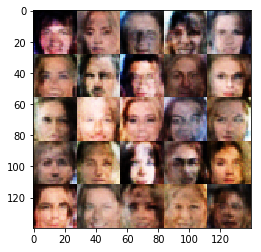

Epoch 1/1---process:1310 Loss of Discriminator: 1.1208958625793457--- Loss of Generator: 0.8547277450561523---
Epoch 1/1---process:1320 Loss of Discriminator: 0.9058457612991333--- Loss of Generator: 1.964863657951355---
Epoch 1/1---process:1330 Loss of Discriminator: 0.9801099300384521--- Loss of Generator: 1.0762813091278076---
Epoch 1/1---process:1340 Loss of Discriminator: 1.010104775428772--- Loss of Generator: 1.651052474975586---
Epoch 1/1---process:1350 Loss of Discriminator: 1.2596373558044434--- Loss of Generator: 0.6523666381835938---
Epoch 1/1---process:1360 Loss of Discriminator: 0.8723181486129761--- Loss of Generator: 1.7847516536712646---
Epoch 1/1---process:1370 Loss of Discriminator: 1.6135766506195068--- Loss of Generator: 0.37065672874450684---
Epoch 1/1---process:1380 Loss of Discriminator: 0.855516254901886--- Loss of Generator: 1.94622802734375---
Epoch 1/1---process:1390 Loss of Discriminator: 0.9825806617736816--- Loss of Generator: 2.417729377746582---
Epoch 1

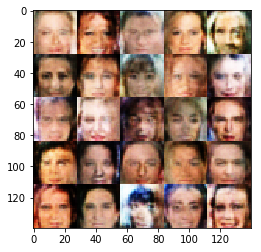

Epoch 1/1---process:1410 Loss of Discriminator: 1.0737537145614624--- Loss of Generator: 1.0045807361602783---
Epoch 1/1---process:1420 Loss of Discriminator: 1.3290890455245972--- Loss of Generator: 2.0388967990875244---
Epoch 1/1---process:1430 Loss of Discriminator: 1.4843202829360962--- Loss of Generator: 0.47144484519958496---
Epoch 1/1---process:1440 Loss of Discriminator: 0.9486067891120911--- Loss of Generator: 1.049382209777832---
Epoch 1/1---process:1450 Loss of Discriminator: 1.1680967807769775--- Loss of Generator: 2.375270366668701---
Epoch 1/1---process:1460 Loss of Discriminator: 0.9443609714508057--- Loss of Generator: 2.1882741451263428---
Epoch 1/1---process:1470 Loss of Discriminator: 1.198634386062622--- Loss of Generator: 3.817467212677002---
Epoch 1/1---process:1480 Loss of Discriminator: 1.0373830795288086--- Loss of Generator: 0.8760050535202026---
Epoch 1/1---process:1490 Loss of Discriminator: 0.9230748414993286--- Loss of Generator: 1.50770103931427---
Epoch 

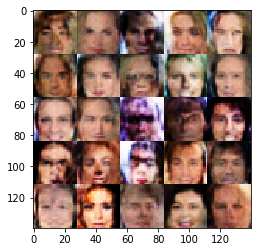

Epoch 1/1---process:1510 Loss of Discriminator: 0.7956395745277405--- Loss of Generator: 2.1867685317993164---
Epoch 1/1---process:1520 Loss of Discriminator: 1.3750011920928955--- Loss of Generator: 2.72959566116333---
Epoch 1/1---process:1530 Loss of Discriminator: 0.8547176122665405--- Loss of Generator: 1.3340156078338623---
Epoch 1/1---process:1540 Loss of Discriminator: 0.870457112789154--- Loss of Generator: 1.752272129058838---
Epoch 1/1---process:1550 Loss of Discriminator: 1.04844069480896--- Loss of Generator: 0.834723949432373---
Epoch 1/1---process:1560 Loss of Discriminator: 1.2583805322647095--- Loss of Generator: 0.5947269201278687---
Epoch 1/1---process:1570 Loss of Discriminator: 0.9654139280319214--- Loss of Generator: 1.035809874534607---
Epoch 1/1---process:1580 Loss of Discriminator: 0.7535556554794312--- Loss of Generator: 1.7857035398483276---
Loss of Discriminator: 0.7535556554794312--- Loss of Generator: 1.7857035398483276---


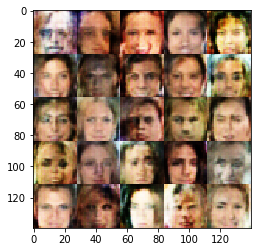

In [71]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.